In [523]:
using Pkg
# Pkg.add("LightGraphs")
# Pkg.add("GraphPlot")
# Pkg.add("Colors")
# Pkg.add("IterTools")
# Pkg.add("Images")
# Pkg.add("Plots")
using Graphs
using GraphPlot
using Colors
using IterTools
using Plots
using Images

In [ ]:
function visualize(adj_matrix)
    g = SimpleGraph(adj_matrix)
    set1 = 1:3
    set2 = 4:6
    node_colors = vcat([colorant"red" for _ in set1], [colorant"blue" for _ in set2])
    gplot(g, layout=spring_layout, nodelabel=1:nv(g), nodefillc=node_colors) 
end



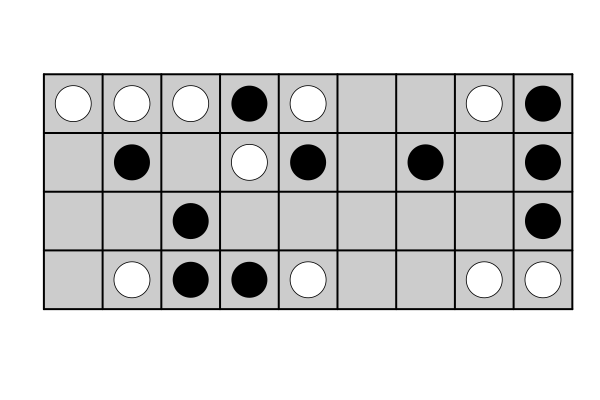

In [492]:
function coord_to_index(x, y)
    return (x - 1) * 9 + y
end

function draw_board()
    # Initialize an 8x8 board with alternating colors
    board = [RGB(0.8, 0.8, 0.8) for _ in 1:10, _ in 1:5]
    plot(heatmap(1:10, 1:5, board, c=:grays, axis=false, border=:none, framestyle=:none, aspect_ratio=:equal))
    # Add vertical lines
    for x in 1:9
        plot!([x, x], [1, 5], lw=2, color=:black, linestyle=:solid)
    end

    # Add horizontal lines
    for y in 1:4
        plot!([1, 10], [y, y], lw=2, color=:black, linestyle=:solid)
    end

    # Add border lines
    # plot!([0.5, 9.5], [0.5, 0.5], lw=2, color=:black, linestyle=:solid)
    plot!([1, 10], [5, 5], lw=2, color=:black, linestyle=:solid)
    # plot!([0.5, 0.5], [0.5, 8.5], lw=2, color=:black, linestyle=:solid)
    plot!([10, 10], [1, 5], lw=2, color=:black, linestyle=:solid)
end


function add_circles!(plot, pieces, color)
    for p in pieces
        circle_color = color == "white" ? RGBA(1, 1, 1, 0.8) : RGBA(0, 0, 0, 0.8)
        scatter!(plot, [p % 9 == 0 ? 9.5 : p % 9 + 0.5], [div(p - 0.1, 9) + 1.5], markershape=:circle, markersize=20, color=circle_color, legend=false)
    end
end

function draw_puzzle(black, white)
    p = draw_board()
    add_circles!(p, black, "black")
    add_circles!(p, white, "white")
    display(p)
end



### Build group codebook

The codebook contains the following matrixes
+ all groups ($45 \times 4$)
+ all three in a row ($N_{3iar} \times 3$)
+ all two in a row($N_{2iar} \times 2$)
+ four in a row ($36 \times 45$)
+ three in a row($36 \times N_{3iar}$)
+ two in a row($36 \times N_{2iar}$)

In [ ]:

all_groups = []
for y in 1:9
    push!(all_groups, [coord_to_index(1, y) coord_to_index(2, y) coord_to_index(3, y) coord_to_index(4, y)])
end
for y in 1:6
    push!(all_groups, [coord_to_index(1, y) coord_to_index(2, y+1) coord_to_index(3, y+2) coord_to_index(4, y+3)])
    push!(all_groups, [coord_to_index(1, y+3) coord_to_index(2, y+2) coord_to_index(3, y+1) coord_to_index(4, y)])
    for x in 1:4
        push!(all_groups, [coord_to_index(x, y) coord_to_index(x, y+1) coord_to_index(x, y+2) coord_to_index(x, y+3)])
    end
end
all_groups = reshape(vcat(all_groups...), 45, 4)

In [ ]:
all_three_in_a_row = reshape(all_groups[:, [1 2 3; 1 2 4; 1 3 4; 2 3 4]], :, 3)
all_three_in_a_row * [10000 100 1]'
enc(x::Matrix)::Matrix = x * [10000 100 1]'
dec(x::Matrix)::Matrix = [div.(x, 10000) mod.(div.(x, 100),100) mod.(x, 100)]
all_three_in_a_row = all_three_in_a_row |> enc |> unique |> hcat |> dec

all_two_in_a_row = reshape(all_groups[:, [1 2; 1 3; 1 4; 2 3; 2 4; 3 4]], :, 2)
all_two_in_a_row * [100 1]'
enc(x::Matrix)::Matrix = x * [100 1]'
dec(x::Matrix)::Matrix = [div.(x, 100) mod.(x, 100)]
all_two_in_a_row = all_two_in_a_row |> enc |> unique |> hcat |> dec

In [255]:
function square_to_group(all_patterns)
    book = zeros(36, size(all_patterns)[1])
    for i in 1: size(all_patterns)[1]
        book[all_patterns[i, :], i] .= 1
    end
    return book
end
four_in_a_row = square_to_group(all_groups)
three_in_a_row = square_to_group(all_three_in_a_row)
two_in_a_row = square_to_group(all_two_in_a_row)

36×210 Matrix{Float64}:
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0     0.0  0.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  1.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0 

### State Matrix and Transformation Matrix

+ group state ($45 \times 10$)
    - one hot
+ transmatrix ($10 \times 10$)
    - $X_{ij}: i \rightarrow j$

Group State
1. Empty
2. Mixed
3. Black-1
4. Black-2
5. Black-3
6. Black-4
7. White-1
8. White-2
9. White-3
10. White-4

In [294]:
BlackTransMatrix = zeros(10, 10)
BlackTransMatrix[1, 3] = 1
BlackTransMatrix[2, 2] = 1
BlackTransMatrix[3, 4] = 1
BlackTransMatrix[4, 5] = 1
BlackTransMatrix[5, 6] = 1
BlackTransMatrix[6, 6] = 1
BlackTransMatrix[7, 2] = 1
BlackTransMatrix[8, 2] = 1
BlackTransMatrix[9, 2] = 1
BlackTransMatrix[10, 10] = 1

WhiteTransMatrix = zeros(10, 10)
WhiteTransMatrix[1, 7] = 1
WhiteTransMatrix[2, 2] = 1
WhiteTransMatrix[3, 2] = 1
WhiteTransMatrix[4, 2] = 1
WhiteTransMatrix[5, 2] = 1
WhiteTransMatrix[6, 6] = 1
WhiteTransMatrix[7, 8] = 1
WhiteTransMatrix[8, 9] = 1
WhiteTransMatrix[9, 10] = 1
WhiteTransMatrix[10, 10] = 1

function update(states::Matrix, square, color)
    matrix = color == "black" ? BlackTransMatrix : WhiteTransMatrix
    states[four_in_a_row[square, :] .== 1, :] *= matrix
end

update (generic function with 4 methods)

In [507]:
function init_state(black, white)
    black = map(x -> x + 1, black)
    white = map(x -> x + 1, white)
    draw_puzzle(black, white)
    group_state = zeros(45, 10)
    group_state[:, 1] .= 1

    for b in black
        update(group_state, b, "black")
    end
    for w in white
        update(group_state, w, "white")
    end

    empty_squares = filter(x -> !((x in black) | (x in white)), 1:36)
    return group_state, empty_squares
end


init_state (generic function with 1 method)

### Strategy

+ My color $M_3 \rightarrow M_4$
+ Prevent opponent color from $O_3 \rightarrow O_4$
+ In player's turn, if the number of remaining steps equals to
    - $3 \rightarrow M_2$
    - $5 \rightarrow M_2, M_1$
    - $\geq 5 \rightarrow M_2, M_1, E, O_1, O_2$
+ In opponent's turn
    - $O_2, M_2, M_1, O_1, E$


In [508]:
function get_candidates(turn_color, empty_squares, group_state, remain_steps, is_player)
    oppo_color = turn_color == "black" ? "white" : "black"

    turn_3iar = all_groups[group_state[:, turn_color == "black" ? 5 : 9] .== 1, :]
    turn_3iar = intersect(unique(turn_3iar), empty_squares)
    if length(turn_3iar) > 0
        return turn_3iar, "Forced Win"
    end

    oppo_3iar = all_groups[group_state[:, oppo_color == "black" ? 5 : 9] .== 1, :]
    oppo_3iar = intersect(unique(oppo_3iar), empty_squares)
    if length(oppo_3iar) > 0
        return oppo_3iar, "Defense"
    end
    if is_player
        if remain_steps <= 3
            cand = all_groups[group_state[:, turn_color == "black" ? 4 : 8] .== 1, :]
            cand = intersect(unique(cand), empty_squares)
            return cand, "Other"
        elseif remain_steps <= 5
            cand_2iar = all_groups[group_state[:, turn_color == "black" ? 4 : 8] .== 1, :]
            cand_2iar = intersect(unique(cand_2iar), empty_squares)
            cand_1iar = all_groups[group_state[:, turn_color == "black" ? 3 : 7] .== 1, :]
            cand_1iar = intersect(unique(cand_1iar), empty_squares)
            return union(cand_2iar, cand_1iar), "Other"
        else
            cand_m2 = all_groups[group_state[:, turn_color == "black" ? 4 : 8] .== 1, :]
            cand_m2 = intersect(unique(cand_m2), empty_squares)
            cand_m1 = all_groups[group_state[:, turn_color == "black" ? 3 : 7] .== 1, :]
            cand_m1 = intersect(unique(cand_m1), empty_squares)
            cand_o2 = all_groups[group_state[:, turn_color == "black" ? 8 : 4] .== 1, :]
            cand_o2 = intersect(unique(cand_o2), empty_squares)
            cand_o1 = all_groups[group_state[:, turn_color == "black" ? 7 : 3] .== 1, :]
            cand_o1 = intersect(unique(cand_o1), empty_squares)
            cand_e = all_groups[group_state[:, 1] .== 1, :]
            cand_e = intersect(unique(cand_e), empty_squares)
            return union(cand_m2, cand_m1, cand_e, cand_o1, cand_o2), "Other"
        end
    else
        cand_m2 = all_groups[group_state[:, turn_color == "black" ? 4 : 8] .== 1, :]
        cand_m2 = intersect(unique(cand_m2), empty_squares)
        cand_m1 = all_groups[group_state[:, turn_color == "black" ? 3 : 7] .== 1, :]
        cand_m1 = intersect(unique(cand_m1), empty_squares)
        cand_o2 = all_groups[group_state[:, turn_color == "black" ? 8 : 4] .== 1, :]
        cand_o2 = intersect(unique(cand_o2), empty_squares)
        cand_o1 = all_groups[group_state[:, turn_color == "black" ? 7 : 3] .== 1, :]
        cand_o1 = intersect(unique(cand_o1), empty_squares)
        cand_e = all_groups[group_state[:, 1] .== 1, :]
        cand_e = intersect(unique(cand_e), empty_squares)
        return union(cand_o2, cand_m2, cand_m1, cand_o1, cand_e), "Other"
    end
end

get_candidates (generic function with 1 method)

In [509]:
function step(group_states, empty_squares, path, turn_color, is_player, depth, max_depth)
    num_node = 0
    if depth >= max_depth
        return [], [], num_node
    end
    opponent_color = turn_color == "black" ? "white" : "black"
    turn_cand, cat = get_candidates(turn_color, empty_squares, group_states, max_depth - depth - !is_player, is_player)
    all_forced_win_paths = []
    forced_win_cand = []
    for piece in turn_cand
        if (depth == max_depth - 1) & (cat != "Forced Win")
            continue
        end
        cp_empty = []
        for p in empty_squares
            if p != piece
                push!(cp_empty, p)
            end
        end
        cp_states = copy(group_states)
        update(cp_states, piece, turn_color)
        cp_path = copy(path)
        push!(cp_path, string(turn_color, "-", piece - 1))
        num_node += 1
        if is_player
            if cat == "Forced Win"
                push!(forced_win_cand, piece - 1)
                push!(all_forced_win_paths, cp_path)
                num_node += 1
            else
                next_fw_cand, next_all_fw_paths, n = step(cp_states, cp_empty, cp_path, opponent_color, false, depth+1, max_depth)
                num_node += n
                if length(next_fw_cand) > 0
                    push!(forced_win_cand, piece - 1)
                    append!(all_forced_win_paths, next_all_fw_paths)
                end
            end
        else
            if cat == "Forced Win"
                num_node += 1
                break
            end
            next_fw_cand, next_all_fw_paths, n = step(cp_states, cp_empty, cp_path, opponent_color, true, depth+1, max_depth)
            num_node += n
            if length(next_fw_cand) > 0
                push!(forced_win_cand, piece - 1)
                append!(all_forced_win_paths, next_all_fw_paths)
            else
                return [], [], num_node
            end
        end
    end
    return forced_win_cand, all_forced_win_paths, num_node
end

step (generic function with 1 method)

In [524]:
function search(black, white, max_depth)
    @time begin
        player_color = length(black) == length(white) ? "black" : "white"
        group_states, empty_squares = init_state(black, white)
        forced_win_cand, all_forced_win_paths, num_node = step(group_states, empty_squares, [], player_color, true, 1, max_depth)
    end
    println(num_node)
    println(forced_win_cand)
    for path in all_forced_win_paths
        println(path)
    end
end


search (generic function with 1 method)

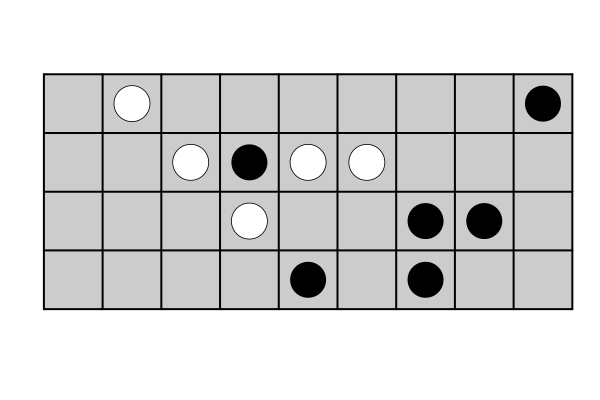

160.812279 seconds (928.15 M allocations: 93.299 GiB, 12.00% gc time, 0.63% compilation time)
time
8117180
Any[29]
Any["white-29", "black-5", "white-2", "black-20", "white-3", "black-0", "white-4"]
Any["white-29", "black-5", "white-2", "black-20", "white-3", "black-4", "white-0"]
Any["white-29", "black-5", "white-20", "black-2", "white-19", "black-18", "white-22"]
Any["white-29", "black-5", "white-20", "black-2", "white-19", "black-22", "white-18"]
Any["white-29", "black-5", "white-20", "black-2", "white-22", "black-19", "white-23"]
Any["white-29", "black-5", "white-20", "black-2", "white-22", "black-23", "white-19"]


In [525]:
black = [12, 24, 25, 31, 33, 8]  # Square index (0-35)
white = [11, 13, 14, 21, 1]  # Square index (0-35)
max_depth = 6 * 2  # win in 6
search(black, white, max_depth)